In [3]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb
from keras import preprocessing

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding

from keras.layers import LSTM
from keras.layers import GRU

2022-12-06 19:01:15.870882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# load imdb data

In [5]:
max_features = 10000 # Number of words to consider as features

# Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [9]:
import pandas as pd
tmp = pd.DataFrame(x_train)
tmp.isnull().any()

0    False
dtype: bool

In [4]:
print(x_train.shape)
print(len(x_train[0]))
print(y_train[0])
print(x_train[0])

(25000,)
218
1
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


# imdb binary clf - densely connected model

## preparing data

In [5]:
# encoding integer sequences into a binary matrix
def vectorize_sequences(sequences, dimension=10000):
    # create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0 # set specific indices of results[i] to 1s
    return results

In [6]:
x_train_v1 = vectorize_sequences(x_train) # vectorized training data
x_test_v1 = vectorize_sequences(x_test) # vectorized test data

y_train_v1 = np.asarray(y_train, dtype = 'float32') # vectorize labels
y_test_v1 = np.asarray(y_test, dtype = 'float32')

In [7]:
print(len(x_train_v1[0]))
print(x_train_v1[0])

10000
[0. 1. 1. ... 0. 0. 0.]


In [8]:
print(len(np.array(x_train_v1[0]))) # one hot encoded
print(sum(np.array(x_train_v1[0]))) # should be equal to len(np.unique((np.array(train_data[0]))))

10000
120.0


In [9]:
x_train_v1.shape

(25000, 10000)

## build model

In [10]:
model1 = models.Sequential()

# two intermediate layers with 16 hiddent units each with relu activation functions (which zero out negative values)
model1.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model1.add(layers.Dense(16, activation='relu'))

# output layer with sigmoid activation function to output something that can be interpreted as probability
model1.add(layers.Dense(1, activation='sigmoid'))

# compile the model
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize model
print(model1.summary())

model1.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

2022-12-05 16:51:44.303304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4585 - accuracy: 0.8240
Epoch 2/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2639 - accuracy: 0.9088
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2031 - accuracy: 0.9279
Epoch 4/4
49/49 [=

In [11]:
test_loss, test_accuracy = model1.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

782/782 [==============================] - 1s 1ms/step - loss: 0.2906 - accuracy: 0.8836
test_loss: 0.291, test_accuracy: 0.884


## Exercise 1
- Try using larger or smaller layers: E.g. 32 units, 128 units
- Instead of two hidden layers, try using a single hidden layer, or three hidden layers

### Exercise 1a

In [12]:
# 32

model1a = models.Sequential()

model1a.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model1a.add(layers.Dense(32, activation='relu'))

model1a.add(layers.Dense(1, activation='sigmoid'))
model1a.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model1a.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

test_loss, test_accuracy = model1a.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

Epoch 1/4
49/49 [==============================] - 1s 10ms/step - loss: 0.4323 - accuracy: 0.8148
Epoch 2/4
49/49 [==============================] - 1s 10ms/step - loss: 0.2406 - accuracy: 0.9122
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.1911 - accuracy: 0.9306
Epoch 4/4
782/782 [==============================] - 1s 905us/step - loss: 0.3147 - accuracy: 0.8799
test_loss: 0.315, test_accuracy: 0.88


In [13]:
# 128
model1a = models.Sequential()

model1a.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model1a.add(layers.Dense(128, activation='relu'))

model1a.add(layers.Dense(1, activation='sigmoid'))
model1a.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model1a.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

test_loss, test_accuracy = model1a.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

Epoch 1/4
49/49 [==============================] - 2s 22ms/step - loss: 0.4299 - accuracy: 0.8005
Epoch 2/4
49/49 [==============================] - 1s 20ms/step - loss: 0.2247 - accuracy: 0.9121
Epoch 3/4
49/49 [==============================] - 1s 21ms/step - loss: 0.1628 - accuracy: 0.9374
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.3549 - accuracy: 0.8774
test_loss: 0.355, test_accuracy: 0.877


### Exercise 1b

In [17]:
# single hidden layer
model1b = models.Sequential()

model1b.add(layers.Dense(1, activation='sigmoid'))
model1b.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model1b.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

test_loss, test_accuracy = model1b.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

Epoch 1/4
49/49 [==============================] - 1s 8ms/step - loss: 0.5819 - accuracy: 0.7786
Epoch 2/4
49/49 [==============================] - 0s 8ms/step - loss: 0.4654 - accuracy: 0.8588
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.3985 - accuracy: 0.8788
Epoch 4/4
782/782 [==============================] - 1s 881us/step - loss: 0.3731 - accuracy: 0.8719
test_loss: 0.373, test_accuracy: 0.872


In [15]:
# two hidden layers
model1b = models.Sequential()

model1b.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model1b.add(layers.Dense(1, activation='sigmoid'))
model1b.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model1b.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

test_loss, test_accuracy = model1b.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4484 - accuracy: 0.8297
Epoch 2/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2779 - accuracy: 0.9071
Epoch 3/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2198 - accuracy: 0.9246
Epoch 4/4
782/782 [==============================] - 1s 858us/step - loss: 0.2846 - accuracy: 0.8850
test_loss: 0.285, test_accuracy: 0.885


In [16]:
# three hidden layers
model1b = models.Sequential()

model1b.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model1b.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model1b.add(layers.Dense(1, activation='sigmoid'))
model1b.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model1b.fit(x_train_v1, y_train_v1, epochs=4, batch_size = 512) # train the model in mini-batches of 512 samples

test_loss, test_accuracy = model1b.evaluate(x_test_v1, y_test_v1)
print("test_loss: %s, test_accuracy: %s" %(np.round(test_loss,3), np.round(test_accuracy,3)))

Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4358 - accuracy: 0.8192
Epoch 2/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2485 - accuracy: 0.9127
Epoch 3/4
49/49 [==============================] - 0s 10ms/step - loss: 0.1930 - accuracy: 0.9290
Epoch 4/4
782/782 [==============================] - 1s 898us/step - loss: 0.3441 - accuracy: 0.8677
test_loss: 0.344, test_accuracy: 0.868


# imdb binary classification with word embeddings
- The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. 
- It takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup

In [19]:
# Turn the lists of integers into a 2D integer tensor of shape (samples, maxlen)

maxlen = 200 # Cuts off the text after this number of words (among the max_features most common words)

from keras.utils import pad_sequences

x_train_v2 = pad_sequences(x_train, maxlen=maxlen) # preprocessing.sequence.
x_test_v2 = pad_sequences(x_test, maxlen=maxlen) # preprocessing.sequence.

In [20]:
print(x_train_v2.shape)
print(len(x_train_v2[0]))
print(x_train_v2[0])
print(y_train[0])

(25000, 200)
200
[   5   25  100   43  838  112   50  670    2    9   35  480  284    5
  150    4  172  112  167    2  336  385   39    4  172 4536 1111   17
  546   38   13  447    4  192   50   16    6  147 2025   19   14   22
    4 1920 4613  469    4   22   71   87   12   16   43  530   38   76
   15   13 1247    4   22   17  515   17   12   16  626   18    2    5
   62  386   12    8  316    8  106    5    4 2223 5244   16  480   66
 3785   33    4  130   12   16   38  619    5   25  124   51   36  135
   48   25 1415   33    6   22   12  215   28   77   52    5   14  407
   16   82    2    8    4  107  117 5952   15  256    4    2    7 3766
    5  723   36   71   43  530  476   26  400  317   46    7    4    2
 1029   13  104   88    4  381   15  297   98   32 2071   56   26  141
    6  194 7486   18    4  226   22   21  134  476   26  480    5  144
   30 5535   18   51   36   28  224   92   25  104    4  226   65   16
   38 1334   88   12   16  283    5   16 4472  113  103   32

## build model

In [22]:
model2 = Sequential()

model2.add(Embedding(10000, 8, input_length=maxlen))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

history2 = model2.fit(x_train_v2, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 1601      
                                                                 
Total params: 81,601
Trainable params: 81,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 1ms/step - loss: 0.5891 - acc: 0.7027 - val_loss: 0.4036 - val_acc: 0.8482
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3106 - acc: 0.8787 - val_loss: 0.3013 - val_acc: 0.8774
Epoch 3/10
625/625 [==============================

## plot the validation ress

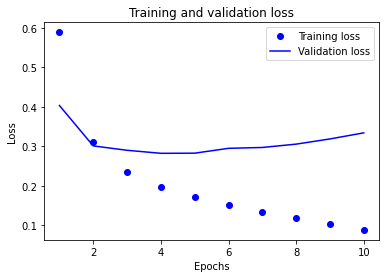

In [23]:
history_dict = history2.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

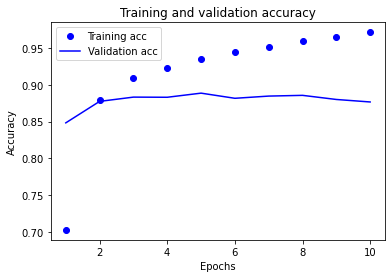

In [24]:
history_dict = history2.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# imdb binary classification with RNNs

In [25]:
# Training the model with Embedding and LSTM layers
model3 = Sequential()

model3.add(Embedding(max_features, 32))
model3.add(LSTM(32))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 

history3 = model3.fit(x_train_v2, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
157/157 [==============================] - 11s 61ms/step - loss: 0.4693 - acc: 0.7781 - val_loss: 0.3363 - val_acc: 0.8658
Epoch 2/5
157/157 [==============================] - 9s 59ms/step - loss: 0.2763 - acc: 0.8900 - val_loss: 0.3317 - val_acc: 0.8736
Epoch 3/5
157/157 [==============================] - 9s 58ms/step - loss: 0.2275 - acc: 0.9133 - val_loss: 0.3347 - val_acc: 0.8796
Epoch 4/5
157/157 [==============================] - 9s 58ms/step - loss: 0.1953 - acc: 0.9276 - val_loss: 0.3311 - val_acc: 0.8804
Epoch 5/5
157/157 [==============================] - 9s 60ms/step - loss: 0.1724 - acc: 0.9391 - val_loss: 0.3609 - val_acc: 0.8666


## plot validation ress

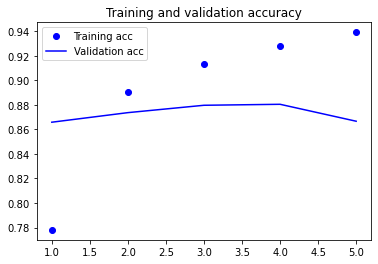

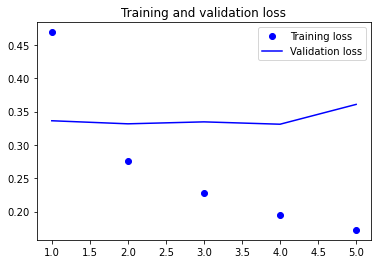

In [26]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Exercise 2
- replace LSTM layer and perform the validation experiments

In [27]:
# Training the model with Embedding and GRU layers
model3a = Sequential()

model3a.add(Embedding(max_features, 32))
model3a.add(GRU(32))
model3a.add(Dense(1, activation='sigmoid'))

model3a.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 

history3a = model3a.fit(x_train_v2, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
157/157 [==============================] - 10s 57ms/step - loss: 0.5208 - acc: 0.7291 - val_loss: 0.3682 - val_acc: 0.8426
Epoch 2/5
157/157 [==============================] - 9s 55ms/step - loss: 0.3019 - acc: 0.8749 - val_loss: 0.3529 - val_acc: 0.8468
Epoch 3/5
157/157 [==============================] - 9s 55ms/step - loss: 0.2479 - acc: 0.9032 - val_loss: 0.3067 - val_acc: 0.8704
Epoch 4/5
157/157 [==============================] - 9s 55ms/step - loss: 0.2108 - acc: 0.9208 - val_loss: 0.3099 - val_acc: 0.8734
Epoch 5/5
157/157 [==============================] - 9s 55ms/step - loss: 0.1851 - acc: 0.9310 - val_loss: 0.3305 - val_acc: 0.8598


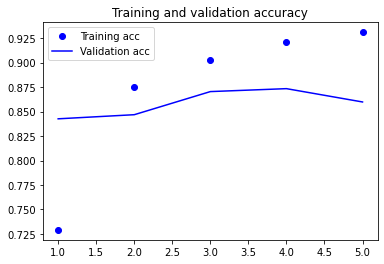

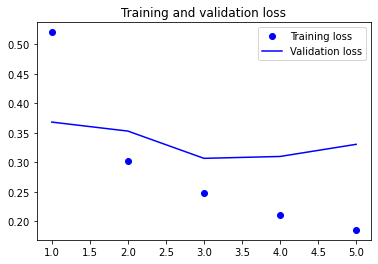

In [28]:
acc = history3a.history['acc']
val_acc = history3a.history['val_acc']
loss = history3a.history['loss']
val_loss = history3a.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# Training the model with Embedding and LSTM layers
model3a = Sequential()

model3a.add(Embedding(max_features, 32))
model3a.add(LSTM(32))
model3a.add(Dense(1, activation='sigmoid'))

model3a.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 

history3a = model3a.fit(x_train_v2, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
157/157 [==============================] - 12s 65ms/step - loss: 0.5104 - acc: 0.7593 - val_loss: 0.4375 - val_acc: 0.7968
Epoch 2/5
157/157 [==============================] - 10s 61ms/step - loss: 0.2885 - acc: 0.8887 - val_loss: 0.2980 - val_acc: 0.8796
Epoch 3/5
157/157 [==============================] - 9s 59ms/step - loss: 0.2285 - acc: 0.9145 - val_loss: 0.4085 - val_acc: 0.8572
Epoch 4/5
157/157 [==============================] - 10s 63ms/step - loss: 0.1999 - acc: 0.9248 - val_loss: 0.3697 - val_acc: 0.8736
Epoch 5/5
157/157 [==============================] - 10s 66ms/step - loss: 0.1744 - acc: 0.9378 - val_loss: 0.3084 - val_acc: 0.8670


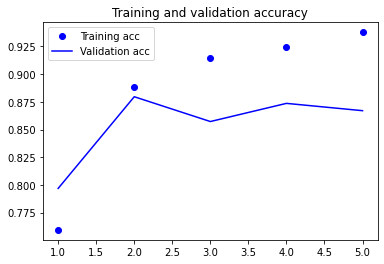

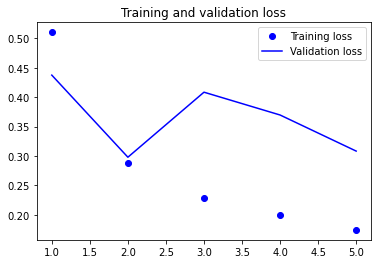

In [30]:
acc = history3a.history['acc']
val_acc = history3a.history['val_acc']
loss = history3a.history['loss']
val_loss = history3a.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()